# Tutorial for the ssSIG package

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import variation    #https://docs.scipy.org/doc/scipy-1.8.0/html-scipyorg/reference/generated/scipy.stats.variation.html
from scipy.stats import pointbiserialr
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from scipy.stats import levene
from scipy.stats import shapiro


import statsmodels as sm
import statsmodels.api as smapi
from statsmodels.stats.multitest import multipletests

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
from sklearn.preprocessing import scale
from sklearn.impute import KNNImputer

#-----------------------------------------------------------------------------
# ---- Linear regression - Using statsmodels
# https://www.statsmodels.org/stable/regression.html
# https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html
import statsmodels.api as smapi
from statsmodels.stats.multitest import multipletests

# generate random Gaussian values
# https://numpy.org/doc/1.16/reference/routines.random.html
from numpy.random import seed
from numpy.random import randn
from numpy.random import normal  #normal([loc, scale, size])
from numpy.random import exponential   #exponential([scale, size])
from numpy.random import lognormal   #lognormal([mean, sigma, size])

#Probability distributions 
# https://docs.scipy.org/doc/scipy/reference/stats.html
from scipy.stats import norm   # norm.pdf(x, loc=0, scale=1)
from scipy.stats import lognorm   # lognorm.pdf(x, s, loc=0, scale=1)

# Calling the finite sample size p-value functions
import ssSIG as ssSIG

## Setting for plots
font = {'size'   : 14}
plt.rc('font', **font)

## One sample

The hypotheses are:
* Null hypothesis - $H_0: \mu=0$
* Alternative hypothesis - $H_1: \mu \neq 0$

### Synthetic data
Let us generate some data obeying a normal distribution $N(\mu_1,\sigma_1^2)$:

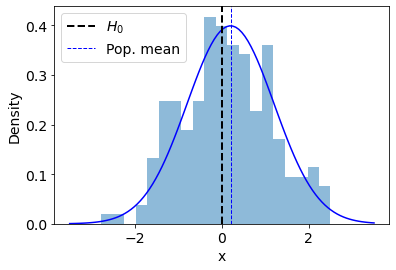

In [4]:
# Null hypothesis: H0: mu = 0
null_mu = 0.

# Data: N(muB,sigmaB^2)
muB = 0.2
sigmaB = 1

# Plot of density histogram of data and probability density function of data
nB=200

# Random seed
#np.random.seed(9) # Good difference n = 200
np.random.seed(100) # Small difference n = 200 

# Random variables
xB = normal(muB,sigmaB,nB)

# Density histogram for the random sample
plt.figure()
plt.hist(xB, bins=20, density=True, alpha = 0.5)
plt.xlabel('x')
plt.ylabel('Density')
#plt.title('Correlation of all metabolites')
x = np.linspace(-3.5,3.5,100)
y1 = norm.pdf(x,loc = muB, scale = sigmaB)
plt.plot(x,y1,'b')
plt.axvline(x = null_mu, color = 'black', ls='--', lw=2, label = "$H_0$")
plt.axvline(x = muB, color = 'blue', ls='--', lw=1, label = "Pop. mean")
plt.legend()

### t-test

A t-test can be run using the function <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html"> `ttest_1samp` </a> from the scipy.stats package.

In [5]:
from scipy.stats import ttest_1samp
alternative = 'two-sided' #Other possibilities:  ‘less’, ‘greater’
s,p = ttest_1samp(xB,null_mu,alternative=alternative)
print('P-value =',p)

P-value = 0.11968740906234471


### Subsampling t-test

The subsampling method using a t-test for random subsamples of the original dataset can be run using the `ttest_1samp_ssSIG` function from the ssSIG package which extends the function `ttest_1samp`. The function `ttest_1samp_ssSIG` uses the same input parameters as `ttest_1samp` plus the following:
* `alpha`: Significance level $\alpha$ (used to calculate the empirical power for subsamples).
* `fmin`,`fmax`,`Df`: Parameters for the list of values for the subsampling fraction $f\in$ [`fmin`,`fmax`]. `Df` is the step of the partition such that the list for $f$ is [fmin, fmin+Df, fmin+2*Df,...].
* `Rsubsamples`: Number of random subsamples used for each value of $f$.
* `th_beta`: Linear regression for $L_{\beta}$ is restricted to values $f<$ `th_beta`.

In [6]:
alpha = 0.05
Df = 0.01
fmin = 0.01
fmax = 1.0
Rsubsamples = 100 # Number of sub-samples for a fraction f of the total sample
th_beta = 0.5
alternative = 'two-sided'

pvalb,R2,slope_Lnpval,ciL_slope_Lnpval,ciU_slope_Lnpval,intercept_Lnpval,ciL_intercept_Lnpval,ciU_intercept_Lnpval,flist,mean_logpval,median_logpval,sd_logpval,logpv_qL,logpv_qU,power,pvalb_beta,R2_beta,slope_Lnpval_beta,ciL_slope_Lnpval_beta,ciU_slope_Lnpval_beta,intercept_Lnpval_beta,ciL_intercept_Lnpval_beta,ciU_intercept_Lnpval_beta = ssSIG.ttest_1samp_ssSIG(xB,null_mu,Rsubsamples,fmin,fmax,Df,alternative=alternative,alpha=alpha,th_beta=th_beta)

print('P-value for Lp =', pvalb)
print('P-value for Lbeta =', pvalb_beta)

P-value for Lp = 6.758273075417e-58
P-value for Lbeta = 1.1661199349600223e-07


Plots of the results:

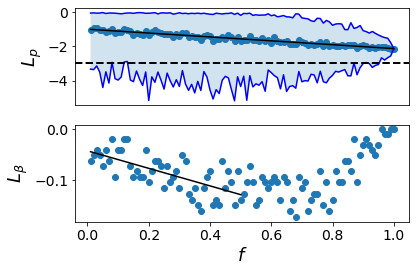

In [7]:
font = {'size'   : 14}
plt.rc('font', **font)

f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]})

a0.plot(flist,mean_logpval,'o-',label='mean')
a0.plot(flist,logpv_qL,'b-')
a0.plot(flist,logpv_qU,'b-')
a0.fill_between(flist,logpv_qL,logpv_qU, alpha = 0.2)
a0.axhline(y = np.log(0.05), color = 'black', ls='--', lw=2)
y_pred = [intercept_Lnpval+slope_Lnpval*x for x in flist]
a0.plot (flist, y_pred, '-', color='black', linewidth=1.5, label='Fit')
a0.set_xlabel('$f$',fontsize=18)
a0.set_ylabel('$L_p$',fontsize=18)
a0.get_xaxis().set_visible(False)

a1.plot(flist,np.log(1-power),'o',label = 'FNR')
y_pred = [intercept_Lnpval_beta+slope_Lnpval_beta*x for x in [min(flist),th_beta]]
a1.plot([min(flist),th_beta], y_pred, '-', color='black', linewidth=1.5, label='Fit')
a1.set_xlabel('$f$',fontsize=18)
a1.set_ylabel(r'$L_{\beta}$',fontsize=18)

f.tight_layout()

## Two samples

### Two normally distributed samples

#### Synthetic data

Two normally distributed samples to simulate a quantity $x$ observed in two groups:
- Group A: $n_A$ observations, $x_A ~ N(\mu_A,\sigma_A^2)$
- Group B: $n_B$ observations, $x_B ~ N(\mu_B,\sigma_B^2)$


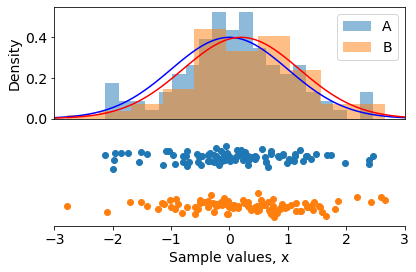

In [10]:
np.random.seed(10)

nA=100
nB=100
muA = 0.0
muB = 0.2
sigmaA = 1.0
sigmaB = 1.0

xA = normal(muA,sigmaA,nA)
xB = normal(muB,sigmaB,nB)

font = {'size'   : 14}
plt.rc('font', **font)

  
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 3]})

a0.hist(xA, bins=20, density=True, alpha = 0.5,label = "A")
a0.hist(xB, bins=10, density=True, alpha = 0.5, label = "B")
x = np.linspace(-3,3,100)

y0 = norm.pdf(x,loc = muA, scale = sigmaA)
y1 = norm.pdf(x,loc = muB, scale = sigmaB)
a0.plot(x,y0,'b')
a0.plot(x,y1,'r')
a0.set_xlim([-3,3])
a0.set_ylabel('Density')
a0.legend()
a0.get_xaxis().set_visible(False)

yrand0 = normal(0.5,0.05,len(xA))
yrand1 = normal(0.,0.05,len(xB))
    
a1.plot(xA,yrand0,'o')
a1.plot(xB,yrand1,'o')
a1.set_xlim([-3,3]) # for np.random.seed(20)
a1.set_ylim([-0.2,0.65])
a1=plt.gca()
a1.get_yaxis().set_visible(False)
a1.spines['right'].set_visible(False)
a1.spines['top'].set_visible(False)
a1.spines['left'].set_visible(False)
a1.spines['bottom'].set_visible(True)
a1.set_xlabel('Sample values, x')

f.tight_layout()

#### *Independent* samples. t-test and subsampling t-test

t-test assuming that the samples are independent using the function <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html"> `ttest_ind` </a>

In [3]:
from scipy.stats import ttest_ind
alternative = 'two-sided' #Other possibilities:  ‘less’, ‘greater’
s,p = ttest_ind(xA,xB,alternative=alternative)
print('P-value =',p)

P-value = 0.17294531622519738


Subsampling t-test:

In [7]:
alpha = 0.05
Df = 0.01
fmin = 0.1
fmax = 1.0
Rsubsamples = 1000 # Number of sub-samples for a fraction f of the total sample
th_beta = 0.5

# t-test
#nan_policy='propagate'
alternative='two-sided'#'less' #'greater'#'two-sided'

# Subsampling
pvalb,R2,slope_Lnpval,ciL_slope_Lnpval,ciU_slope_Lnpval,intercept_Lnpval,ciL_intercept_Lnpval,ciU_intercept_Lnpval,flist,mean_logpval,median_logpval,sd_logpval,logpv_qL,logpv_qU,power,pvalb_beta,R2_beta,slope_Lnpval_beta,ciL_slope_Lnpval_beta,ciU_slope_Lnpval_beta,intercept_Lnpval_beta,ciL_intercept_Lnpval_beta,ciU_intercept_Lnpval_beta = ssSIG.ttest_ind_ssSIG(xA,xB,Rsubsamples,fmin,fmax,Df,alternative, alpha = alpha)

print('P-value for Lp =', pvalb)
print('P-value for Lbeta =', pvalb_beta)


P-value = 0.17294531622519738
P-value for Lp = 3.932867321614733e-78
P-value for Lbeta = 3.282566604242024e-05


Plots of the subsampling results:

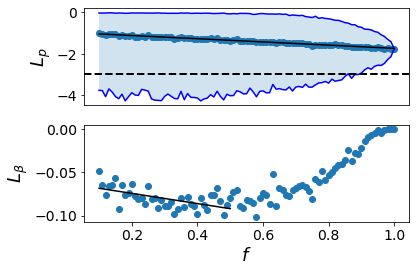

In [8]:
font = {'size'   : 14}
plt.rc('font', **font)

f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]})

a0.plot(flist,mean_logpval,'o-',label='mean')
a0.plot(flist,logpv_qL,'b-')
a0.plot(flist,logpv_qU,'b-')
a0.fill_between(flist,logpv_qL,logpv_qU, alpha = 0.2)
a0.axhline(y = np.log(0.05), color = 'black', ls='--', lw=2)
y_pred = [intercept_Lnpval+slope_Lnpval*x for x in flist]
a0.plot (flist, y_pred, '-', color='black', linewidth=1.5, label='Fit')
a0.set_xlabel('$f$',fontsize=18)
a0.set_ylabel('$L_p$',fontsize=18)
a0.get_xaxis().set_visible(False)


a1.plot(flist,np.log(1-power),'o',label = 'FNR')
y_pred = [intercept_Lnpval_beta+slope_Lnpval_beta*x for x in [min(flist),0.5]]
a1.plot([min(flist),0.5], y_pred, '-', color='black', linewidth=1.5, label='Fit')
a1.set_xlabel('$f$',fontsize=18)
a1.set_ylabel(r'$L_{\beta}$',fontsize=18)
#a1.legend()

f.tight_layout()

#### *Related* samples - t-test and subsampling t-test

t-test assuming that the samples are independent using the function <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html#scipy.stats.ttest_rel"> `ttest_rel` </a>

In [4]:
from scipy.stats import ttest_rel
alternative = 'two-sided' #Other possibilities:  ‘less’, ‘greater’
s,p = ttest_rel(xA,xB,alternative=alternative)
print('P-value =',p)

P-value = 0.1603446482621382


In [5]:
alpha = 0.05
Df = 0.01
fmin = 0.1
fmax = 1.0
Rsubsamples = 1000 # Number of sub-samples for a fraction f of the total sample
th_beta = 0.5

# t-test
#nan_policy='propagate'
alternative='two-sided'#'less' #'greater'#'two-sided'

# Subsampling
pvalb,R2,slope_Lnpval,ciL_slope_Lnpval,ciU_slope_Lnpval,intercept_Lnpval,ciL_intercept_Lnpval,ciU_intercept_Lnpval,flist,mean_logpval,median_logpval,sd_logpval,logpv_qL,logpv_qU,power,pvalb_beta,R2_beta,slope_Lnpval_beta,ciL_slope_Lnpval_beta,ciU_slope_Lnpval_beta,intercept_Lnpval_beta,ciL_intercept_Lnpval_beta,ciU_intercept_Lnpval_beta = ssSIG.ttest_rel_ssSIG(xA,xB,Rsubsamples,fmin,fmax,Df,alternative, alpha = alpha,th_beta=th_beta)

print('P-value for Lp =', pvalb)
print('P-value for Lbeta =', pvalb_beta)


P-value for Lp = 1.5193452951687e-78
P-value for Lbeta = 2.7746591714797503e-09


Plots of the subsampling results:

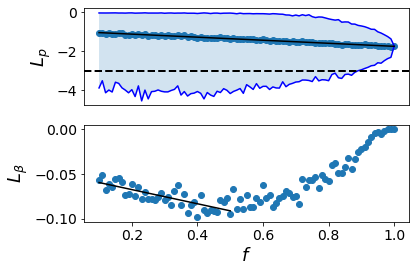

In [6]:
font = {'size'   : 14}
plt.rc('font', **font)

f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]})

a0.plot(flist,mean_logpval,'o-',label='mean')
a0.plot(flist,logpv_qL,'b-')
a0.plot(flist,logpv_qU,'b-')
a0.fill_between(flist,logpv_qL,logpv_qU, alpha = 0.2)
a0.axhline(y = np.log(0.05), color = 'black', ls='--', lw=2)
y_pred = [intercept_Lnpval+slope_Lnpval*x for x in flist]
a0.plot (flist, y_pred, '-', color='black', linewidth=1.5, label='Fit')

a0.set_xlabel('$f$',fontsize=18)
a0.set_ylabel('$L_p$',fontsize=18)
a0.get_xaxis().set_visible(False)

a1.plot(flist,np.log(1-power),'o',label = 'FNR')
y_pred = [intercept_Lnpval_beta+slope_Lnpval_beta*x for x in [min(flist),0.5]]
a1.plot([min(flist),0.5], y_pred, '-', color='black', linewidth=1.5, label='Fit')
a1.set_xlabel('$f$',fontsize=18)
a1.set_ylabel(r'$L_{\beta}$',fontsize=18)

f.tight_layout()

#### *Related* samples - Wilcoxon and subsampling Wilcoxon

t-test assuming that the samples are independent using the function <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html#scipy.stats.wilcoxon"> `wilcoxon` </a>

In [4]:
from scipy.stats import ttest_rel
alternative = 'two-sided' #Other possibilities:  ‘less’, ‘greater’
s,p = wilcoxon(xA,xB,alternative=alternative)
print('P-value =',p)

P-value = 0.12431015694745697


In [5]:
alpha = 0.05
Df = 0.01
fmin = 0.1
fmax = 1.0
Rsubsamples = 1000 # Number of sub-samples for a fraction f of the total sample
th_beta = 0.5

# t-test
#nan_policy='propagate'
alternative='two-sided'#'less' #'greater'#'two-sided'

# Subsampling
pvalb,R2,slope_Lnpval,ciL_slope_Lnpval,ciU_slope_Lnpval,intercept_Lnpval,ciL_intercept_Lnpval,ciU_intercept_Lnpval,flist,mean_logpval,median_logpval,sd_logpval,logpv_qL,logpv_qU,power,pvalb_beta,R2_beta,slope_Lnpval_beta,ciL_slope_Lnpval_beta,ciU_slope_Lnpval_beta,intercept_Lnpval_beta,ciL_intercept_Lnpval_beta,ciU_intercept_Lnpval_beta = ssSIG.wilcoxon_ssSIG(xA,xB,Rsubsamples,fmin,fmax,Df, alternative,  alpha = alpha,th_beta=th_beta)

print('P-value for Lp =', pvalb)
print('P-value for Lbeta =', pvalb_beta)


P-value for Lp = 3.376876824379069e-66
P-value for Lbeta = 7.349061317313626e-11


Plots of the subsampling results:

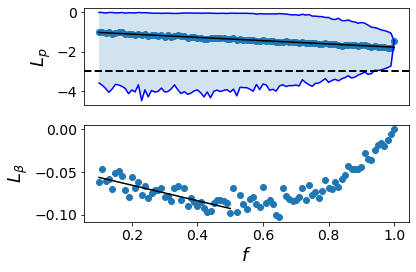

In [7]:
font = {'size'   : 14}
plt.rc('font', **font)

f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]})

a0.plot(flist,mean_logpval,'o-',label='mean')
a0.plot(flist,logpv_qL,'b-')
a0.plot(flist,logpv_qU,'b-')
a0.fill_between(flist,logpv_qL,logpv_qU, alpha = 0.2)
a0.axhline(y = np.log(0.05), color = 'black', ls='--', lw=2)
y_pred = [intercept_Lnpval+slope_Lnpval*x for x in flist]
a0.plot (flist, y_pred, '-', color='black', linewidth=1.5, label='Fit')

a0.set_xlabel('$f$',fontsize=18)
a0.set_ylabel('$L_p$',fontsize=18)
a0.get_xaxis().set_visible(False)

a1.plot(flist,np.log(1-power),'o',label = 'FNR')
y_pred = [intercept_Lnpval_beta+slope_Lnpval_beta*x for x in [min(flist),0.5]]
a1.plot([min(flist),0.5], y_pred, '-', color='black', linewidth=1.5, label='Fit')
a1.set_xlabel('$f$',fontsize=18)
a1.set_ylabel(r'$L_{\beta}$',fontsize=18)

f.tight_layout()

### Two log-normal samples

#### Synthetic data

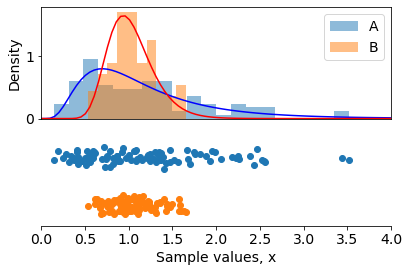

In [9]:
#np.random.seed(10)
np.random.seed(20)

nA=100
nB=100
muA = 0.0
muB = 0.0
sigmaA = 0.6
sigmaB = 0.25

xA = lognormal(muA,sigmaA,nA)
xB = lognormal(muB,sigmaB,nB)

font = {'size'   : 14}
plt.rc('font', **font)

f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 3]})

a0.hist(xA, bins=20, density=True, alpha = 0.5,label = "A")
a0.hist(xB, bins=10, density=True, alpha = 0.5, label = "B")
x = np.linspace(0.001,5,100)

y0 = lognorm.pdf(x,sigmaA,loc = muA)
y1 = lognorm.pdf(x,sigmaB,loc = muB)
a0.plot(x,y0,'b')
a0.plot(x,y1,'r')
a0.set_xlim([0,4]) # for np.random.seed(20)
a0.set_ylabel('Density')
a0.legend()
a0.get_xaxis().set_visible(False)

yrand0 = np.zeros(len(xA))
yrand1 = np.zeros(len(xB))
for i in range(len(yrand0)):
    yrand0[i] = normal(0.5,0.05)
    yrand1[i] = normal(0.,0.05)
    
a1.plot(xA,yrand0,'o')
a1.plot(xB,yrand1,'o')
a1.set_xlim([0,4]) # for np.random.seed(20)
a1.set_ylim([-0.2,0.65])
a1=plt.gca()
a1.get_yaxis().set_visible(False)
a1.spines['right'].set_visible(False)
a1.spines['top'].set_visible(False)
a1.spines['left'].set_visible(False)
a1.spines['bottom'].set_visible(True)
a1.set_xlabel('Sample values, x')

f.tight_layout()

#### ***t-test***

In [10]:
alpha = 0.05
Df = 0.01
fmin = 0.1
fmax = 1.0
Rsubsamples = 1000 # Number of sub-samples for a fraction f of the total sample
th_beta = 0.5

#nan_policy='propagate'
alternative='less'#'less' #'greater'#'two-sided'
pvalb,R2,slope_Lnpval,ciL_slope_Lnpval,ciU_slope_Lnpval,intercept_Lnpval,ciL_intercept_Lnpval,ciU_intercept_Lnpval,flist,mean_logpval,median_logpval,sd_logpval,logpv_qL,logpv_qU,power,pvalb_beta,R2_beta,slope_Lnpval_beta,ciL_slope_Lnpval_beta,ciU_slope_Lnpval_beta,intercept_Lnpval_beta,ciL_intercept_Lnpval_beta,ciU_intercept_Lnpval_beta = ssSIG.ttest_ind_ssSIG(xA,xB,Rsubsamples,fmin,fmax,Df,alternative, alpha = alpha)

print('P-value for Lp =', pvalb)
print('P-value for Lbeta =', pvalb_beta)


P-value for Lp = 1.0
P-value for Lbeta = 0.9999999999999115


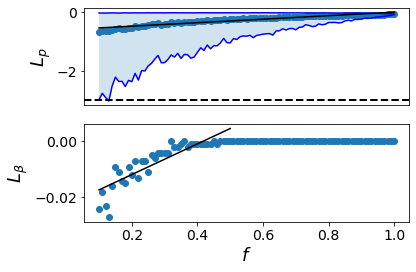

In [11]:
font = {'size'   : 14}
plt.rc('font', **font)

f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]})

a0.plot(flist,mean_logpval,'o-',label='mean')
a0.plot(flist,logpv_qL,'b-')
a0.plot(flist,logpv_qU,'b-')
a0.fill_between(flist,logpv_qL,logpv_qU, alpha = 0.2)
a0.axhline(y = np.log(0.05), color = 'black', ls='--', lw=2)
y_pred = [intercept_Lnpval+slope_Lnpval*x for x in flist]
a0.plot (flist, y_pred, '-', color='black', linewidth=1.5, label='Fit')

    #plt.plot(nAset,np.log(np.zeros(len(nAset))+0.05))
a0.set_xlabel('$f$',fontsize=18)
a0.set_ylabel('$L_p$',fontsize=18)
a0.get_xaxis().set_visible(False)
#a0.legend()

a1.plot(flist,np.log(1-power),'o',label = 'FNR')
y_pred = [intercept_Lnpval_beta+slope_Lnpval_beta*x for x in [min(flist),0.5]]
a1.plot([min(flist),0.5], y_pred, '-', color='black', linewidth=1.5, label='Fit')
a1.set_xlabel('$f$',fontsize=18)
a1.set_ylabel(r'$L_{\beta}$',fontsize=18)
#a1.legend()

f.tight_layout()

### Mann-Whitney test

In [15]:
alpha = 0.05
Df = 0.01
fmin = 0.1
fmax = 1.0
Rsubsamples = 1000 # Number of sub-samples for a fraction f of the total sample
th_beta = 0.5

# Mann-whitney
alternative='less'#'greater'#'less'#'two-sided'
pvalb,R2,slope_Lnpval,ciL_slope_Lnpval,ciU_slope_Lnpval,intercept_Lnpval,ciL_intercept_Lnpval,ciU_intercept_Lnpval,flist,mean_logpval,median_logpval,sd_logpval,logpv_qL,logpv_qU,power,pvalb_beta,R2_beta,slope_Lnpval_beta,ciL_slope_Lnpval_beta,ciU_slope_Lnpval_beta,intercept_Lnpval_beta,ciL_intercept_Lnpval_beta,ciU_intercept_Lnpval_beta = ssSIG.mannwhitneyu_ssSIG(xA,xB,Rsubsamples,fmin,fmax,Df,alternative,alpha = alpha,th_beta=th_beta)
#pvalb,R2,slope_Lnpval,ciL_slope_Lnpval,ciU_slope_Lnpval,intercept_Lnpval,ciL_intercept_Lnpval,ciU_intercept_Lnpval,flist,mean_log10pval,median_log10pval,log10pv_qL,log10pv_qU = ssSIG.mannwhitneyu_ssSIG(xA,xB,nrealisations,fmin,fmax,Df,alternative)

print('P-value for Lp =', pvalb)
print('P-value for Lbeta =', pvalb_beta)

P-value for Lp = 1.0
P-value for Lbeta = 0.999999999999549


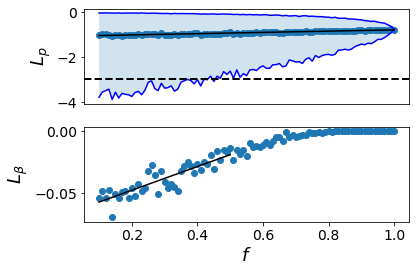

In [16]:
font = {'size'   : 14}
plt.rc('font', **font)

f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]})

a0.plot(flist,mean_logpval,'o-',label='mean')
a0.plot(flist,logpv_qL,'b-')
a0.plot(flist,logpv_qU,'b-')
a0.fill_between(flist,logpv_qL,logpv_qU, alpha = 0.2)
a0.axhline(y = np.log(0.05), color = 'black', ls='--', lw=2)
y_pred = [intercept_Lnpval+slope_Lnpval*x for x in flist]
a0.plot (flist, y_pred, '-', color='black', linewidth=1.5, label='Fit')

    #plt.plot(nAset,np.log(np.zeros(len(nAset))+0.05))
a0.set_xlabel('$f$',fontsize=18)
a0.set_ylabel('$L_p$',fontsize=18)
a0.get_xaxis().set_visible(False)
#a0.legend()

a1.plot(flist,np.log(1-power),'o',label = 'FNR')
y_pred = [intercept_Lnpval_beta+slope_Lnpval_beta*x for x in [min(flist),0.5]]
a1.plot([min(flist),0.5], y_pred, '-', color='black', linewidth=1.5, label='Fit')
a1.set_xlabel('$f$',fontsize=18)
a1.set_ylabel(r'$L_{\beta}$',fontsize=18)
#a1.legend()

f.tight_layout()

### Logistic regression

In [17]:
alpha = 0.05
Df = 0.01
fmin = 0.1
fmax = 1.0
Rsubsamples = 1000 # Number of sub-samples for a fraction f of the total sample
th_beta = 0.5

# logistic regression
pvalb,R2,slope_Lnpval,ciL_slope_Lnpval,ciU_slope_Lnpval,intercept_Lnpval,ciL_intercept_Lnpval,ciU_intercept_Lnpval,flist,mean_logpval,median_logpval,sd_logpval,logpv_qL,logpv_qU,power,pvalb_beta,R2_beta,slope_Lnpval_beta,ciL_slope_Lnpval_beta,ciU_slope_Lnpval_beta,intercept_Lnpval_beta,ciL_intercept_Lnpval_beta,ciU_intercept_Lnpval_beta = ssSIG.logreg_ssSIG(xA,xB,Rsubsamples,fmin,fmax,Df,alpha=alpha,th_beta=th_beta)

print('P-value for Lp =', pvalb)
print('P-value for Lbeta =', pvalb_beta)

P-value for Lp = 2.785294536599429e-92
P-value for Lbeta = 4.7125928383345e-16


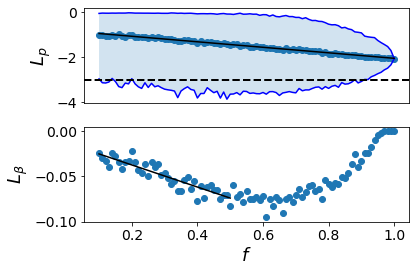

In [18]:
font = {'size'   : 14}
plt.rc('font', **font)

f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]})

a0.plot(flist,mean_logpval,'o-',label='mean')
a0.plot(flist,logpv_qL,'b-')
a0.plot(flist,logpv_qU,'b-')
a0.fill_between(flist,logpv_qL,logpv_qU, alpha = 0.2)
a0.axhline(y = np.log(0.05), color = 'black', ls='--', lw=2)
y_pred = [intercept_Lnpval+slope_Lnpval*x for x in flist]
a0.plot (flist, y_pred, '-', color='black', linewidth=1.5, label='Fit')

    #plt.plot(nAset,np.log(np.zeros(len(nAset))+0.05))
a0.set_xlabel('$f$',fontsize=18)
a0.set_ylabel('$L_p$',fontsize=18)
a0.get_xaxis().set_visible(False)
#a0.legend()

a1.plot(flist,np.log(1-power),'o',label = 'FNR')
y_pred = [intercept_Lnpval_beta+slope_Lnpval_beta*x for x in [min(flist),0.5]]
a1.plot([min(flist),0.5], y_pred, '-', color='black', linewidth=1.5, label='Fit')
a1.set_xlabel('$f$',fontsize=18)
a1.set_ylabel(r'$L_{\beta}$',fontsize=18)
#a1.set_ylim([-2,0.2])
#a1.legend()

f.tight_layout()

### Kolmogorov-Smirnov test

In [19]:
alpha = 0.05
Df = 0.01
fmin = 0.1
fmax = 1.0
Rsubsamples = 1000 # Number of sub-samples for a fraction f of the total sample
th_beta = 0.5

# ks_2samp
alternative='less'#'greater'#'less'#'two-sided'
pvalb,R2,slope_Lnpval,ciL_slope_Lnpval,ciU_slope_Lnpval,intercept_Lnpval,ciL_intercept_Lnpval,ciU_intercept_Lnpval,flist,mean_logpval,median_logpval,sd_logpval,logpv_qL,logpv_qU,power,pvalb_beta,R2_beta,slope_Lnpval_beta,ciL_slope_Lnpval_beta,ciU_slope_Lnpval_beta,intercept_Lnpval_beta,ciL_intercept_Lnpval_beta,ciU_intercept_Lnpval_beta = ssSIG.ks_2samp_ssSIG(xA,xB,Rsubsamples,fmin,fmax,Df,alternative,alpha=alpha,th_beta=th_beta)

print('P-value for Lp =', pvalb)
print('P-value for Lbeta =', pvalb_beta)

P-value for Lp = 8.57899854651934e-114
P-value for Lbeta = 5.804857172801608e-17


/tmp/ipykernel_169100/3378385809.py:20: RuntimeWarning: divide by zero encountered in log
  a1.plot(flist,np.log(1-power),'o',label = 'FNR')


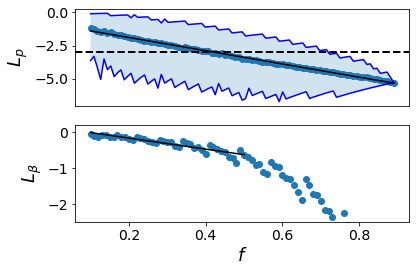

In [20]:
font = {'size'   : 14}
plt.rc('font', **font)

f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]})

a0.plot(flist,mean_logpval,'o-',label='mean')
a0.plot(flist,logpv_qL,'b-')
a0.plot(flist,logpv_qU,'b-')
a0.fill_between(flist,logpv_qL,logpv_qU, alpha = 0.2)
a0.axhline(y = np.log(0.05), color = 'black', ls='--', lw=2)
y_pred = [intercept_Lnpval+slope_Lnpval*x for x in flist]
a0.plot (flist, y_pred, '-', color='black', linewidth=1.5, label='Fit')

    #plt.plot(nAset,np.log(np.zeros(len(nAset))+0.05))
a0.set_xlabel('$f$',fontsize=18)
a0.set_ylabel('$L_p$',fontsize=18)
a0.get_xaxis().set_visible(False)
#a0.legend()

a1.plot(flist,np.log(1-power),'o',label = 'FNR')
y_pred = [intercept_Lnpval_beta+slope_Lnpval_beta*x for x in [min(flist),0.5]]
a1.plot([min(flist),0.5], y_pred, '-', color='black', linewidth=1.5, label='Fit')
a1.set_xlabel('$f$',fontsize=18)
a1.set_ylabel(r'$L_{\beta}$',fontsize=18)
a1.set_ylim([-2.5,0.2])
#a1.legend()

f.tight_layout()

## $k$ samples

The one-way ANOVA and Kruskal-Wallis tests for $k$ independent samples have been implemented within the subsampling paradigm. With the current implementation, it is possible to do tests for **up to $k = 10$ samples**. Here we illustrate these methods for $k = 3$ samples.

### Synthetic data

Three normally distributed samples to simulate a quantity $x$ observed in three groups:
- Group A: $n_A$ observations, $x_A ~ N(\mu_A,\sigma_A^2)$
- Group B: $n_B$ observations, $x_B ~ N(\mu_B,\sigma_B^2)$
- Group C: $n_C$ observations, $x_C ~ N(\mu_C,\sigma_C^2)$


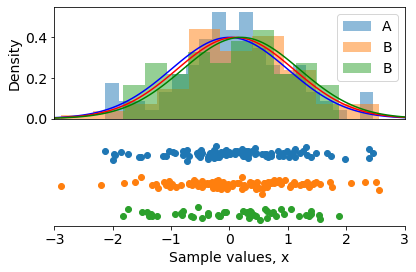

In [9]:
#np.random.seed(10)
np.random.seed(10)

nA=100
nB=100
nC=50
muA = 0.0
muB = 0.1
muC = 0.2
sigmaA = 1.0
sigmaB = 1.0
sigmaC = 1.0

xA = normal(muA,sigmaA,nA)
xB = normal(muB,sigmaB,nB)
xC = normal(muC,sigmaC,nC)

font = {'size'   : 14}
plt.rc('font', **font)

  
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 3]})

a0.hist(xA, bins=20, density=True, alpha = 0.5,label = "A")
a0.hist(xB, bins=10, density=True, alpha = 0.5, label = "B")
a0.hist(xC, bins=10, density=True, alpha = 0.5, label = "B")
#plt.title('Correlation of all metabolites')
x = np.linspace(-3,3,100)

y0 = norm.pdf(x,loc = muA, scale = sigmaA)
y1 = norm.pdf(x,loc = muB, scale = sigmaB)
y2 = norm.pdf(x,loc = muC, scale = sigmaC)
a0.plot(x,y0,'b')
a0.plot(x,y1,'r')
a0.plot(x,y2,'g')
#a0.set_xlim([0,5]) # for np.random.seed(10)
a0.set_xlim([-3,3]) # for np.random.seed(20)
#a0.set_xlabel('x')
a0.set_ylabel('Density')
a0.legend()
#a0=plt.gca()
#a1.set_aspect(1)
a0.get_xaxis().set_visible(False)
#a0.get_xaxis().set_visible(False)

yrand0 = normal(0.5,0.05,len(xA))
yrand1 = normal(0.,0.05,len(xB))
yrand2 = normal(-0.5,0.05,len(xC))
    
a1.plot(xA,yrand0,'o')
a1.plot(xB,yrand1,'o')
a1.plot(xC,yrand2,'o')
#a1.set_xlim([0,5])
#a1.set_xlim([0,5]) # for np.random.seed(10)
a1.set_xlim([-3,3]) # for np.random.seed(20)
a1.set_ylim([-0.7,0.7])
#plt.axhline(x = 0, color = 'black', ls='--', lw=2, label = "$H_0$")
a1=plt.gca()
#a1.set_aspect(1)
#ax.get_xaxis().set_visible(False)
a1.get_yaxis().set_visible(False)
#axes.axis('off')
a1.spines['right'].set_visible(False)
a1.spines['top'].set_visible(False)
a1.spines['left'].set_visible(False)
a1.spines['bottom'].set_visible(True)
a1.set_xlabel('Sample values, x')

f.tight_layout()

#### *Independent* samples. One-way **ANOVA** test

One-way ANOVA test assuming that the samples are independent using the function <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html"> `f_oneway` </a>

In [15]:
from scipy.stats import f_oneway
s,p = f_oneway(xA,xB,xC)
print('P-value =',p)

P-value = 0.3042394431987156


Subsampling one-way ANOVA test (note that the data input format which is different to the functions for 2 samples):

In [17]:
alpha = 0.05
Df = 0.01
fmin = 0.1
fmax = 1.0
Rsubsamples = 1000 # Number of sub-samples for a fraction f of the total sample
th_beta = 0.5


# Subsampling
data = [xA,xB,xC]
pvalb,R2,slope_Lnpval,ciL_slope_Lnpval,ciU_slope_Lnpval,intercept_Lnpval,ciL_intercept_Lnpval,ciU_intercept_Lnpval,flist,mean_logpval,median_logpval,sd_logpval,logpv_qL,logpv_qU,power,pvalb_beta,R2_beta,slope_Lnpval_beta,ciL_slope_Lnpval_beta,ciU_slope_Lnpval_beta,intercept_Lnpval_beta,ciL_intercept_Lnpval_beta,ciU_intercept_Lnpval_beta = ssSIG.f_oneway_ssSIG(data,Rsubsamples,fmin,fmax,Df, alpha, th_beta)

print('P-value for Lp =', pvalb)
print('P-value for Lbeta =', pvalb_beta)


P-value for Lp = 5.090611221914559e-30
P-value for Lbeta = 0.9973100264845903


Plots of the subsampling results:

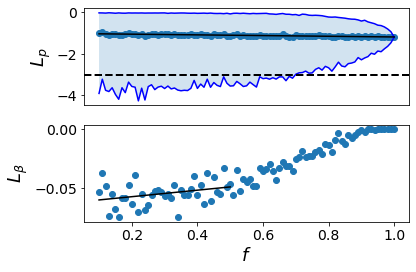

In [12]:
font = {'size'   : 14}
plt.rc('font', **font)

f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]})

a0.plot(flist,mean_logpval,'o-',label='mean')
a0.plot(flist,logpv_qL,'b-')
a0.plot(flist,logpv_qU,'b-')
a0.fill_between(flist,logpv_qL,logpv_qU, alpha = 0.2)
a0.axhline(y = np.log(0.05), color = 'black', ls='--', lw=2)
y_pred = [intercept_Lnpval+slope_Lnpval*x for x in flist]
a0.plot (flist, y_pred, '-', color='black', linewidth=1.5, label='Fit')

    #plt.plot(nAset,np.log(np.zeros(len(nAset))+0.05))
a0.set_xlabel('$f$',fontsize=18)
a0.set_ylabel('$L_p$',fontsize=18)
a0.get_xaxis().set_visible(False)
#a0.legend()

a1.plot(flist,np.log(1-power),'o',label = 'FNR')
y_pred = [intercept_Lnpval_beta+slope_Lnpval_beta*x for x in [min(flist),0.5]]
a1.plot([min(flist),0.5], y_pred, '-', color='black', linewidth=1.5, label='Fit')
a1.set_xlabel('$f$',fontsize=18)
a1.set_ylabel(r'$L_{\beta}$',fontsize=18)
#a1.legend()

f.tight_layout()

#### *Independent* samples. **Kruskal-Wallis** test

Kruskal-Wallis test assuming that the samples are independent using the function <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html"> `kruskal` </a>

In [19]:
from scipy.stats import kruskal
s,p = kruskal(xA,xB,xC)
print('P-value =',p)

P-value = 0.3088270017035544


Subsampling Kruskal-Wallis test (note that the data input format which is different to the functions for 2 samples):

In [20]:
alpha = 0.05
Df = 0.01
fmin = 0.1
fmax = 1.0
Rsubsamples = 1000 # Number of sub-samples for a fraction f of the total sample
th_beta = 0.5

data = [xA,xB,xC]  
pvalb,R2,slope_Lnpval,ciL_slope_Lnpval,ciU_slope_Lnpval,intercept_Lnpval,ciL_intercept_Lnpval,ciU_intercept_Lnpval,flist,mean_logpval,median_logpval,sd_logpval,logpv_qL,logpv_qU,power,pvalb_beta,R2_beta,slope_Lnpval_beta,ciL_slope_Lnpval_beta,ciU_slope_Lnpval_beta,intercept_Lnpval_beta,ciL_intercept_Lnpval_beta,ciU_intercept_Lnpval_beta = ssSIG.kruskal_ssSIG(data,Rsubsamples,fmin,fmax,Df, alpha, th_beta)

print('P-value for Lp =', pvalb)
print('P-value for Lbeta =', pvalb_beta)


P-value for Lp = 3.7094528659499744e-28
P-value for Lbeta = 0.9604655456394755


Plots of the subsampling results:

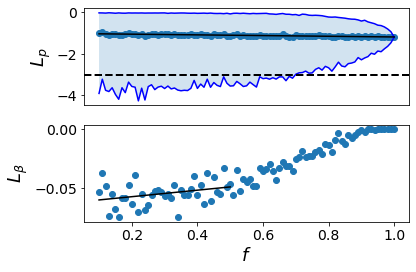

In [12]:
font = {'size'   : 14}
plt.rc('font', **font)

f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]})

a0.plot(flist,mean_logpval,'o-',label='mean')
a0.plot(flist,logpv_qL,'b-')
a0.plot(flist,logpv_qU,'b-')
a0.fill_between(flist,logpv_qL,logpv_qU, alpha = 0.2)
a0.axhline(y = np.log(0.05), color = 'black', ls='--', lw=2)
y_pred = [intercept_Lnpval+slope_Lnpval*x for x in flist]
a0.plot (flist, y_pred, '-', color='black', linewidth=1.5, label='Fit')

    #plt.plot(nAset,np.log(np.zeros(len(nAset))+0.05))
a0.set_xlabel('$f$',fontsize=18)
a0.set_ylabel('$L_p$',fontsize=18)
a0.get_xaxis().set_visible(False)
#a0.legend()

a1.plot(flist,np.log(1-power),'o',label = 'FNR')
y_pred = [intercept_Lnpval_beta+slope_Lnpval_beta*x for x in [min(flist),0.5]]
a1.plot([min(flist),0.5], y_pred, '-', color='black', linewidth=1.5, label='Fit')
a1.set_xlabel('$f$',fontsize=18)
a1.set_ylabel(r'$L_{\beta}$',fontsize=18)
#a1.legend()

f.tight_layout()

## Multiple testing. **Metabolomics gastric cancer example**

The data from <a href="https://www.nature.com/articles/bjc2015414#Sec9"> Chan et al BMJ (2016) 114, 59 </a>. Urine NMR data set consisting of 149 named metabolites. The primary outcome for this paper was the urine was Gastric Cancer (GC; n=43) v Benign Tumor (BN; n=40) v Healthy Control (HE; n=40).

Here, we apply the subsampling method to identify metabolites that differ between two classes (Healthy vs. Benign) and three classes (Benign vs. Gastric cancer). Analyses for the Healthy vs. Gastric cancer and Benight vs. Gastric cancer camparisons can be run using the function `ssSIG.Multiple_tests_2classes`, as illustrated here for the Healthy vs. Benign comparison. Metabolomic data and results from a previous run are available from the `Data` folder as well.

Data is also provided to study the effect of neoadjuvant chemotherapy on breast cancer patients. This is uses a plasma LC-MS dataset from <a href="https://europepmc.org/abstract/MED/24114462"> Hilvo et al. Int. J. of Cancer 134, 1725 (2014). </a> that can be studied with subsampling tests for two variables with the function `ssSIG.Multiple_tests_2classes` as illustrated here for the Healthy vs. Benign comparison in the gastric cancer example.

### Two classes: Healthy vs. Benign

Two options of analysis are offered:
- Option 1 reads the metabolomics data and runs the subsampling analysis test. This can take time to run unless the number of subsamples (`Rsubsamples`) is set to a small value which is not recommended (the calculation of the subsample false negative rate is not accurate for a small number of random subsamples).

The metabolomic data consists consists of 

    - Rows: One row for each individual
    - Columns: Metabolite columns (named "M1", "M2",...) and a column named "class" with information about the class of each individuals (0: Healthy, 1: Benign).

- Option 2 reads the results from subsampling t-tests run previously with.
    - alpha = 0.05
    - fmin = 0.1
    - fmax = 0.7
    - Df = 0.05
    - Rsubsamples = 5000
    - th_beta = 0.5

#### Option 1 - Slower: Run the subsampling analysis from metabolomics data 

Read the metabolomic data and define variables needed for the analysis

In [35]:
features = pd.read_csv("Data/Metabolomics_Healthy_Benign_ST001047.csv")

classname = 'class' # Name of the column with the class variable
featurenames = list(features.columns)
featurenames.remove(classname) # Extract the name of the metabolites

**t-test subsampling method** (Mann-Whitney (MW), Kolmorov-Smirnov (KS) and a test for the logistic regression coefficient (LR) can be run in a similar way by changing the setting for the `SigMethod` variable below).

In [ ]:
#!!!!!
# ONLY RUN THIS IF THE DATA HAS NOT BEEN READ FROM A PREVIOUSLY SAVED FILE!!
#!!!!!
import time

start = time.time()

alpha = 0.05
fmin = 0.1
fmax = 0.7
Df = 0.05
Rsubsamples = 5000 # Number of sub-samples for a fraction f of the total sample
th_beta = 0.5

classname = 'class'
datain = features #[met_names]
#featurenames = met_names #[:-1]

SigMethod = "TT" # Other possibilities: "MW" , "KS", "LR"
R2,slope_Lnpval,ciL_slope_Lnpval,ciU_slope_Lnpval,intercept_Lnpval,ciL_intercept_Lnpval,ciU_intercept_Lnpval,pvalb,pvalb_beta = ssSIG.Multiple_tests_2classes(datain,featurenames,classname,Rsubsamples,fmin,fmax,Df,SigMethod,alpha,th_beta)

# Grab Currrent Time After Running the Code
end = time.time()

#Subtract Start Time from The End Time
total_time = end - start
print("\n"+ str(total_time))

ssSIG_DF = pd.DataFrame({"R2": R2, "slope_Lnpval": slope_Lnpval, "ciL_slope_Lnpval": ciL_slope_Lnpval, "ciU_slope_Lnpval": ciU_slope_Lnpval,
                          "intercept_Lnpval": intercept_Lnpval, "ciL_intercept_Lnpval": ciL_intercept_Lnpval, "ciU_intercept_Lnpval": ciU_intercept_Lnpval, 
                          "pv-b":pvalb, "pvalb_beta":pvalb_beta})

ssSIG_DF['pvMaxSize'] = pv
ssSIG_DF['pvMaxSize_corrected'] = pvalBH[1]
ssSIG_DF

#### Option 2 - Faster: Read results from the `Data` directory

In [28]:
ssSIG_DF = pd.read_csv('Data/Healthy_Benign_ST001047_pvSize_nr_5000_fmin_0.1_fmax_0.7_Df_0.05_TT_.csv')


In [29]:
ssSIG_DF

,met_names,R2,slope_Lnpval,ciL_slope_Lnpval,ciU_slope_Lnpval,intercept_Lnpval,ciL_intercept_Lnpval,ciU_intercept_Lnpval,pv-b,pvalb_beta,pvMaxSize,pvMaxSize_corrected
0,M1,0.990372,-1.290551,-1.380209,-1.200893,-0.810871,-0.847883,-0.773858,1.022211e-11,0.000074,0.106670,0.629061
1,M2,0.777244,0.443617,0.276282,0.610952,-1.276404,-1.345483,-1.207326,9.999252e-01,0.888681,0.377041,0.718735
2,M3,0.994242,0.743132,0.703285,0.782978,-1.057000,-1.073449,-1.040550,1.000000e+00,0.999990,0.787628,0.908790
3,M4,0.991725,0.526066,0.492207,0.559925,-1.001814,-1.015792,-0.987837,1.000000e+00,0.999963,0.576327,0.794387
4,M5,0.918790,-0.728446,-0.881039,-0.575852,-0.947183,-1.010176,-0.884190,4.501556e-07,0.999999,0.140600,0.659364
...,...,...,...,...,...,...,...,...,...,...,...,...
131,M144,0.994004,-0.765111,-0.806980,-0.723243,-0.961314,-0.978598,-0.944030,9.556376e-13,0.998759,0.241182,0.670635
132,M146,0.176721,-0.264617,-0.667048,0.137813,-1.315413,-1.481542,-1.149284,8.680592e-02,0.000074,0.890554,0.927123
133,M147,0.871834,0.176800,0.129037,0.224563,-1.034840,-1.054557,-1.015122,9.999955e-01,0.530669,0.387998,0.718735
134,M148,0.857481,0.508212,0.362226,0.654198,-1.189324,-1.249589,-1.129059,9.999923e-01,0.984349,0.685224,0.839554


#### Correction for multiple testing and simple analysis

Once we have calculated the `ssSIG_DF` dataframe (option 1) or read it (option 2), we add columns for corrected P-values for the slope of $\bar{L}_p$ and $L_{\beta}$ (false discovery rate, Benjamini-Hochberg)

In [33]:
alphasig=0.05
pvbcorrected = multipletests(ssSIG_DF['pv-b'], alpha=alphasig, method = 'fdr_bh')
ssSIG_DF['pv-b-corrected'] = pvbcorrected[1]

pvbcorrected_beta = multipletests(ssSIG_DF['pvalb_beta'].dropna(), alpha=alphasig, method = 'fdr_bh')
ssSIG_DF['pvalb_beta-corrected'] = pvbcorrected_beta[1]

In [34]:
print("Number of metabolites with $p<alpha$:" + str(np.count_nonzero(ssSIG_DF['pvMaxSize']<alphasig)))
print("Number of metabolites with $q<alpha$ (FDR corrected):" + str(np.count_nonzero(ssSIG_DF['pvMaxSize_corrected']<alphasig)))
print("Number of metabolites with $q_p<alpha$ (FDR corrected):" + str(np.count_nonzero(ssSIG_DF['pv-b-corrected']<alphasig)))
print("Number of metabolites with $q_beta<alpha$ (FDR corrected):" + str(np.count_nonzero(ssSIG_DF['pvalb_beta-corrected']<alphasig)))
print("Number of metabolites with $q_p<alpha$ and $q_beta<alpha$ (FDR corrected):" + str(np.count_nonzero((ssSIG_DF['pvalb_beta-corrected']<alphasig)&(ssSIG_DF['pv-b-corrected']<alphasig))))

Number of metabolites with $p<alpha$:16
Number of metabolites with $q<alpha$ (FDR corrected):6
Number of metabolites with $q_p<alpha$ (FDR corrected):60
Number of metabolites with $q_beta<alpha$ (FDR corrected):41
Number of metabolites with $q_p<alpha$ and $q_beta<alpha$ (FDR corrected):33


#### Plot of corrected P-values for the slope of $\bar{L}_p$ and $L_{\beta}$

Text(0, 0.5, '$\\ln q_p$')

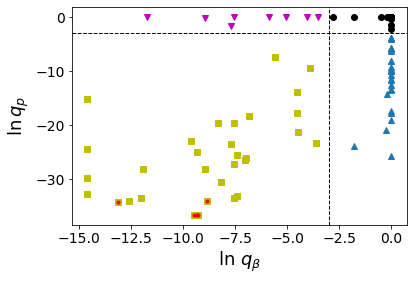

In [32]:
###---- Annotation of points: https://matplotlib.org/stable/tutorials/text/annotations.html#sphx-glr-tutorials-text-annotations-py

## Setting for plots
font = {'size'   : 14}
plt.rc('font', **font)

plt.figure()
#plt.plot(np.log(ssSIG_DF['pvalb_beta-corrected']),np.log(ssSIG_DF['pv-b-corrected']),'o')
plt.plot(np.log(ssSIG_DF[(ssSIG_DF['pvalb_beta-corrected']>=0.05)&(ssSIG_DF['pv-b-corrected']<0.05)]['pvalb_beta-corrected']),
         np.log(ssSIG_DF[(ssSIG_DF['pvalb_beta-corrected']>=0.05)&(ssSIG_DF['pv-b-corrected']<0.05)]['pv-b-corrected']),'^')

plt.plot(np.log(ssSIG_DF[(ssSIG_DF['pvalb_beta-corrected']<0.05)&(ssSIG_DF['pv-b-corrected']>=0.05)]['pvalb_beta-corrected']),
         np.log(ssSIG_DF[(ssSIG_DF['pvalb_beta-corrected']<0.05)&(ssSIG_DF['pv-b-corrected']>=0.05)]['pv-b-corrected']),'vm')

plt.plot(np.log(ssSIG_DF[(ssSIG_DF['pvalb_beta-corrected']<0.05)&(ssSIG_DF['pv-b-corrected']<0.05)]['pvalb_beta-corrected']),
         np.log(ssSIG_DF[(ssSIG_DF['pvalb_beta-corrected']<0.05)&(ssSIG_DF['pv-b-corrected']<0.05)]['pv-b-corrected']),'ys')
plt.plot(np.log(ssSIG_DF[ssSIG_DF['pvMaxSize_corrected']<0.05]['pvalb_beta-corrected']),np.log(ssSIG_DF[ssSIG_DF['pvMaxSize_corrected']<0.05]['pv-b-corrected']),'.r')
plt.plot(np.log(ssSIG_DF[(ssSIG_DF['pv-b-corrected']>=0.05)&(ssSIG_DF['pvalb_beta-corrected']>=0.05)]['pvalb_beta-corrected']),
         np.log(ssSIG_DF[(ssSIG_DF['pv-b-corrected']>=0.05)&(ssSIG_DF['pvalb_beta-corrected']>=0.05)]['pv-b-corrected']),'ko')

plt.axhline(y = np.log(0.05), color = 'black', ls='--', lw=1)
plt.axvline(x = np.log(0.05), color = 'black', ls='--', lw=1)

plt.xlabel(r'ln $q_{\beta}$',fontsize=18)
plt.ylabel('$\ln q_p$',fontsize=18) #('intercept $ln(p_v)$')

### Three classes: Healthy, benign and gastric cancer

#### Option 1 - Slower: Run the subsampling analysis from metabolomics data 

In [22]:
features = pd.read_csv("Data/Metabolomics_Healthy_Benign_GastricCancer_ST001047.csv")

classname = 'class'
featurenames = list(features.columns)
featurenames.remove(classname)

In [ ]:
#!!!!!
# ONLY RUN THIS IF THE DATA HAS NOT BEEN READ FROM A PREVIOUSLY SAVED FILE!!
#!!!!!
import time

start = time.time()

alpha = 0.05
Df = 0.05
fmin = 0.1
fmax = 0.7
Rsubsamples = 5000 #5000 # Number of sub-samples for a fraction f of the total sample
th_beta = 0.5

classname = 'class'
datain = features #[met_names]
#featurenames = met_names #[:-1]

SigMethod = "ANOVA"  #Other possibilities: "KW" 
R2,slope_Lnpval,ciL_slope_Lnpval,ciU_slope_Lnpval,intercept_Lnpval,ciL_intercept_Lnpval,ciU_intercept_Lnpval,pvalb,pvalb_beta = ssSIG.Multiple_tests_3classes(datain,featurenames,classname,Rsubsamples,fmin,fmax,Df,SigMethod,alpha,th_beta)

# Grab Currrent Time After Running the Code
end = time.time()

#Subtract Start Time from The End Time
total_time = end - start
print("\n"+ str(total_time))

ssSIG_DF = pd.DataFrame({"R2": R2, "slope_Lnpval": slope_Lnpval, "ciL_slope_Lnpval": ciL_slope_Lnpval, "ciU_slope_Lnpval": ciU_slope_Lnpval,
                          "intercept_Lnpval": intercept_Lnpval, "ciL_intercept_Lnpval": ciL_intercept_Lnpval, "ciU_intercept_Lnpval": ciU_intercept_Lnpval, 
                          "pv-b":pvalb, "pvalb_beta":pvalb_beta})

ssSIG_DF['pvMaxSize'] = pv
ssSIG_DF['pvMaxSize_corrected'] = pvalBH[1]
ssSIG_DF

#### Option 2 - Faster: Read results from the `Data` directory

In [36]:
ssSIG_DF = pd.read_csv('Data/Healthy_Benign_GastricCancer_ST001047_pvSize_nr_5000_fmin_0.1_fmax_0.7_Df_0.05_ANOVA_.csv')


#### Correction for multiple testing and simple analysis

Once we have calculated the `ssSIG_DF` dataframe (option 1) or read it (option 2), we add columns for corrected P-values for the slope of $\bar{L}_p$ and $L_{\beta}$ (false discovery rate, Benjamini-Hochberg)

In [37]:
alphasig=0.05
pvbcorrected = multipletests(ssSIG_DF['pv-b'], alpha=alphasig, method = 'fdr_bh')
ssSIG_DF['pv-b-corrected'] = pvbcorrected[1]

pvbcorrected_beta = multipletests(ssSIG_DF['pvalb_beta'].dropna(), alpha=alphasig, method = 'fdr_bh')
ssSIG_DF['pvalb_beta-corrected'] = pvbcorrected_beta[1]

In [38]:
print("Number of metabolites with $p<alpha$:" + str(np.count_nonzero(ssSIG_DF['pvMaxSize']<alphasig)))
print("Number of metabolites with $q<alpha$ (FDR corrected):" + str(np.count_nonzero(ssSIG_DF['pvMaxSize_corrected']<alphasig)))
print("Number of metabolites with $q_p<alpha$ (FDR corrected):" + str(np.count_nonzero(ssSIG_DF['pv-b-corrected']<alphasig)))
print("Number of metabolites with $q_beta<alpha$ (FDR corrected):" + str(np.count_nonzero(ssSIG_DF['pvalb_beta-corrected']<alphasig)))
print("Number of metabolites with $q_p<alpha$ and $q_beta<alpha$ (FDR corrected):" + str(np.count_nonzero((ssSIG_DF['pvalb_beta-corrected']<alphasig)&(ssSIG_DF['pv-b-corrected']<alphasig))))

Number of metabolites with $p<alpha$:34
Number of metabolites with $q<alpha$ (FDR corrected):15
Number of metabolites with $q_p<alpha$ (FDR corrected):71
Number of metabolites with $q_beta<alpha$ (FDR corrected):57
Number of metabolites with $q_p<alpha$ and $q_beta<alpha$ (FDR corrected):57


#### Plot of corrected P-values for the slope of $\bar{L}_p$ and $L_{\beta}$

Text(0, 0.5, '$\\ln q_p$')

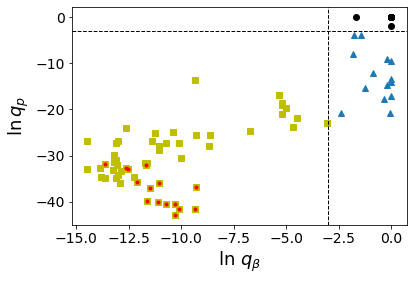

In [39]:
###---- Annotation of points: https://matplotlib.org/stable/tutorials/text/annotations.html#sphx-glr-tutorials-text-annotations-py

## Setting for plots
font = {'size'   : 14}
plt.rc('font', **font)

plt.figure()
plt.plot(np.log(ssSIG_DF[(ssSIG_DF['pvalb_beta-corrected']>=0.05)&(ssSIG_DF['pv-b-corrected']<0.05)]['pvalb_beta-corrected']),
         np.log(ssSIG_DF[(ssSIG_DF['pvalb_beta-corrected']>=0.05)&(ssSIG_DF['pv-b-corrected']<0.05)]['pv-b-corrected']),'^')

plt.plot(np.log(ssSIG_DF[(ssSIG_DF['pvalb_beta-corrected']<0.05)&(ssSIG_DF['pv-b-corrected']>=0.05)]['pvalb_beta-corrected']),
         np.log(ssSIG_DF[(ssSIG_DF['pvalb_beta-corrected']<0.05)&(ssSIG_DF['pv-b-corrected']>=0.05)]['pv-b-corrected']),'vm')

plt.plot(np.log(ssSIG_DF[(ssSIG_DF['pvalb_beta-corrected']<0.05)&(ssSIG_DF['pv-b-corrected']<0.05)]['pvalb_beta-corrected']),
         np.log(ssSIG_DF[(ssSIG_DF['pvalb_beta-corrected']<0.05)&(ssSIG_DF['pv-b-corrected']<0.05)]['pv-b-corrected']),'ys')
plt.plot(np.log(ssSIG_DF[ssSIG_DF['pvMaxSize_corrected']<0.05]['pvalb_beta-corrected']),np.log(ssSIG_DF[ssSIG_DF['pvMaxSize_corrected']<0.05]['pv-b-corrected']),'.r')
plt.plot(np.log(ssSIG_DF[(ssSIG_DF['pv-b-corrected']>=0.05)&(ssSIG_DF['pvalb_beta-corrected']>=0.05)]['pvalb_beta-corrected']),
         np.log(ssSIG_DF[(ssSIG_DF['pv-b-corrected']>=0.05)&(ssSIG_DF['pvalb_beta-corrected']>=0.05)]['pv-b-corrected']),'ko')

plt.axhline(y = np.log(0.05), color = 'black', ls='--', lw=1)
plt.axvline(x = np.log(0.05), color = 'black', ls='--', lw=1)

plt.xlabel(r'ln $q_{\beta}$',fontsize=18)
plt.ylabel('$\ln q_p$',fontsize=18) #('intercept $ln(p_v)$')

